In [1]:
import os
import sys
sys.path.append('../mlai_research/')
import log
import utils
import cv2
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2hsv
from skimage.filters import threshold_sauvola
from skimage.segmentation import mark_boundaries
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
from rasterio.plot import show
from shapely.geometry import box, mapping
import geopandas as gpd
import rasterio
import rasterio.plot
import glob
import matplotlib.pyplot as plt

In [2]:
logger = log.get_logger(__name__)
conf = utils.load_config('base')

10-Dec-23 00:21:06 - INFO - Starting 'load_config'.
10-Dec-23 00:21:06 - INFO - Finished 'load_config' in 0.0695 secs.


In [3]:
def load_cropped_tifs(path):
    return glob.glob(f'{path}*.tif')


def plot_cropped_tifs(cropped_tifs, title):
    ncols = 3 # set number of columns (use 3 to demonstrate the change)
    nrows = len(cropped_tifs) // ncols + (len(cropped_tifs) % ncols > 0) # calculate number of rows

    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=18, y=0.95)

    for n, file in enumerate(cropped_tifs):
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, n + 1)
        # Plot raster crop
        saved_clipped_raster_io = rasterio.open(f"{file}")
        rasterio.plot.show(saved_clipped_raster_io, ax=ax)
        # chart formatting
        ax.set_title(os.path.basename(file), fontsize=8)
        ax.axis('off')
    plt.show()

In [5]:
cropped_tif_fns = load_cropped_tifs("../data/02_intermediate/cropped/")
cropped_tif_fns = cropped_tif_fns[:9]

In [9]:
cropped_tif_fns

['../data/02_intermediate/cropped/143_dsm_Other.tif',
 '../data/02_intermediate/cropped/137_rgba_Xanthium.tif',
 '../data/02_intermediate/cropped/86_rgba_Datura.tif',
 '../data/02_intermediate/cropped/90_dtm_Datura.tif',
 '../data/02_intermediate/cropped/85_dtm_Datura.tif',
 '../data/02_intermediate/cropped/81_dtm_Xanthium.tif',
 '../data/02_intermediate/cropped/78_dtm_Xanthium.tif',
 '../data/02_intermediate/cropped/152_rgba_Other.tif',
 '../data/02_intermediate/cropped/88_dsm_Other.tif']

In [10]:
img = rasterio.open(f"{cropped_tif_fns[1]}")

In [11]:
img.shape

(37, 37)

In [12]:
img.count

4

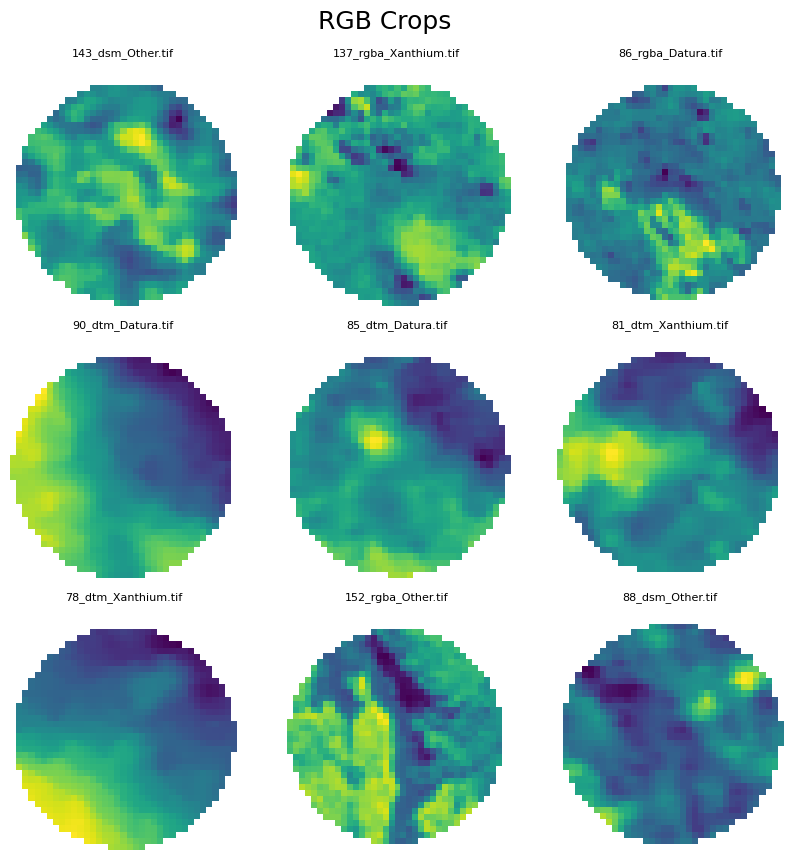

In [4]:

plot_cropped_tifs(cropped_tif_fns, "RGB Crops")

In [105]:
def plot_images(normalized_image, segmented_image, masked_image):
    # Set up the plot with 4 columns
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    # for i in range(num_images):
    # Plot the normalized image in the first column
    axes[0].imshow(normalized_image)
    axes[0].set_title('Normalized Image')

    # Plot the processed image with boundaries in the third column
    axes[1].imshow(mark_boundaries(normalized_image, segmented_image))
    axes[1].set_title('Segmented Image')

    # Plot the masked image in the fourth column
    axes[2].imshow(masked_image)
    axes[2].set_title('Masked Image')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

def create_center_segment_mask(segmentation, image_shape):
    # Step 1: Identify the center point of the image
    center_point = (image_shape[0] // 2, image_shape[1] // 2)

    # Step 2: Identify the segment label at the center point
    center_segment_label = segmentation[center_point]

    # Step 3: Create a mask by comparing the segmentation array with the center segment label
    mask = segmentation == center_segment_label

    # Step 4: Zero out all other segments by multiplying the original image with the mask
    # This step would be done outside this function, when you have the original image available

    return mask


def apply_mask(image, mask):
    # Ensure mask is boolean
    mask = mask.astype(bool)
    
    # Expand dimensions of the mask to match the image
    mask = np.expand_dims(mask, axis=-1)
    
    # Apply the mask to the image
    masked_image = image * mask
    
    return masked_image

15-Nov-23 02:00:52 - INFO - RGB image shape: (87, 88, 3)


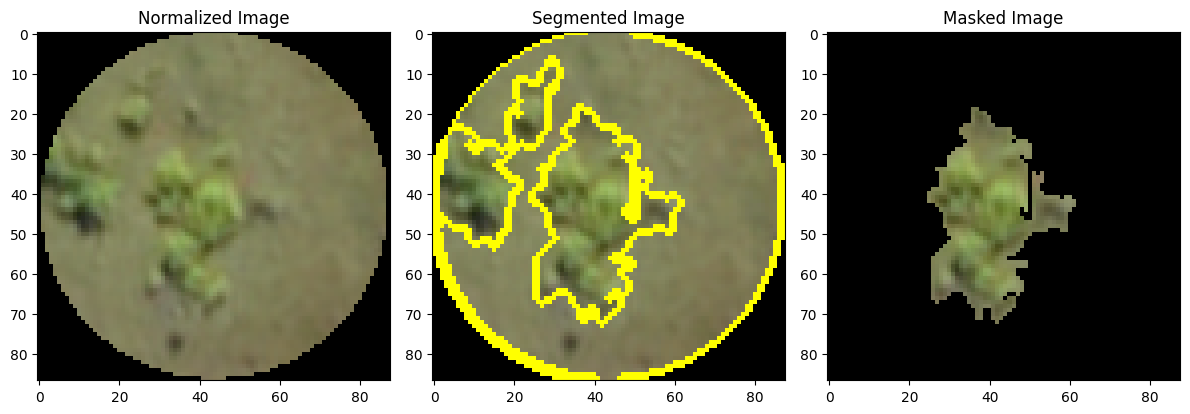

In [106]:
cropped_rgb_7cm = rasterio.open(f"{cropped_tif_fns[0]}")
# convert raster to numpy array
cropped_rgb_7cm_np = cropped_rgb_7cm.read().transpose(1, 2, 0)
img_rgb = cropped_rgb_7cm_np[:, :, :3]
logger.info(f'RGB image shape: {img_rgb.shape}')
segments_fz = felzenszwalb(img_rgb, scale=150, sigma=0.5, min_size=100)
mask = create_center_segment_mask(segments_fz, img_rgb.shape)
masked_image = apply_mask(img_rgb, mask)
plot_images(img_rgb, segments_fz, masked_image)

15-Nov-23 02:01:02 - INFO - RGB image shape: (87, 88, 3)


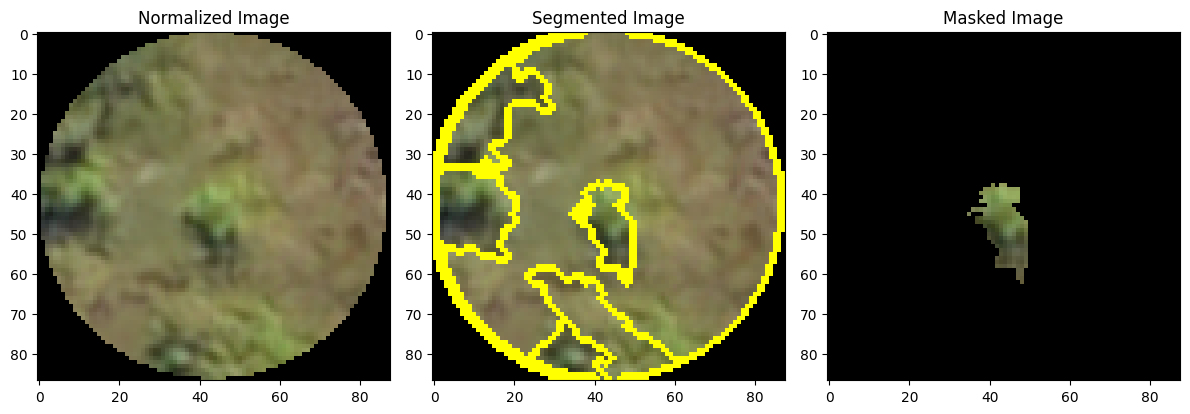

In [107]:
cropped_rgb_7cm = rasterio.open(f"{cropped_tif_fns[1]}")
# convert raster to numpy array
cropped_rgb_7cm_np = cropped_rgb_7cm.read().transpose(1, 2, 0)
img_rgb = cropped_rgb_7cm_np[:, :, :3]
logger.info(f'RGB image shape: {img_rgb.shape}')
segments_fz = felzenszwalb(img_rgb, scale=150, sigma=0.5, min_size=100)
mask = create_center_segment_mask(segments_fz, img_rgb.shape)
masked_image = apply_mask(img_rgb, mask)
plot_images(img_rgb, segments_fz, masked_image)

15-Nov-23 02:01:09 - INFO - RGB image shape: (88, 87, 3)


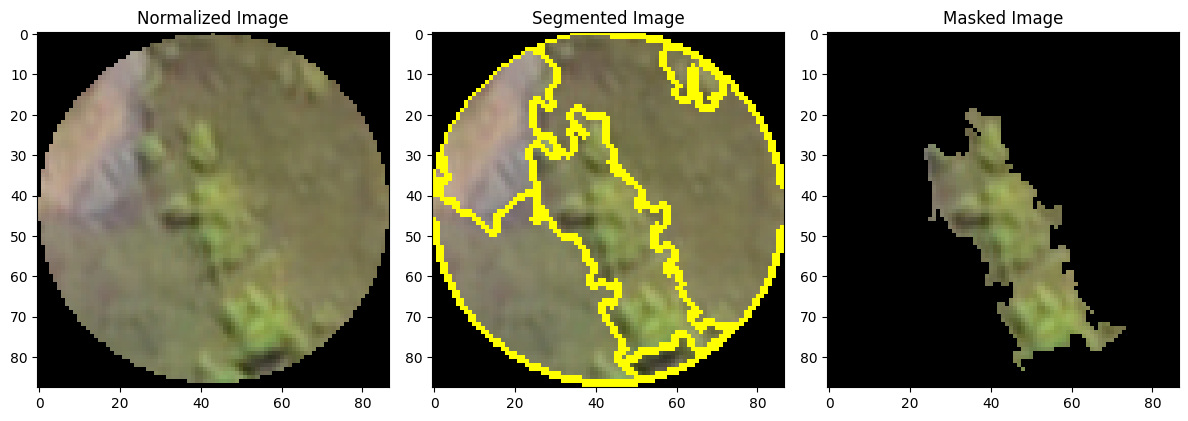

In [108]:
cropped_rgb_7cm = rasterio.open(f"{cropped_tif_fns[2]}")
# convert raster to numpy array
cropped_rgb_7cm_np = cropped_rgb_7cm.read().transpose(1, 2, 0)
img_rgb = cropped_rgb_7cm_np[:, :, :3]
logger.info(f'RGB image shape: {img_rgb.shape}')
segments_fz = felzenszwalb(img_rgb, scale=150, sigma=0.5, min_size=100)
mask = create_center_segment_mask(segments_fz, img_rgb.shape)
masked_image = apply_mask(img_rgb, mask)
plot_images(img_rgb, segments_fz, masked_image)

15-Nov-23 02:01:15 - INFO - RGB image shape: (87, 88, 3)


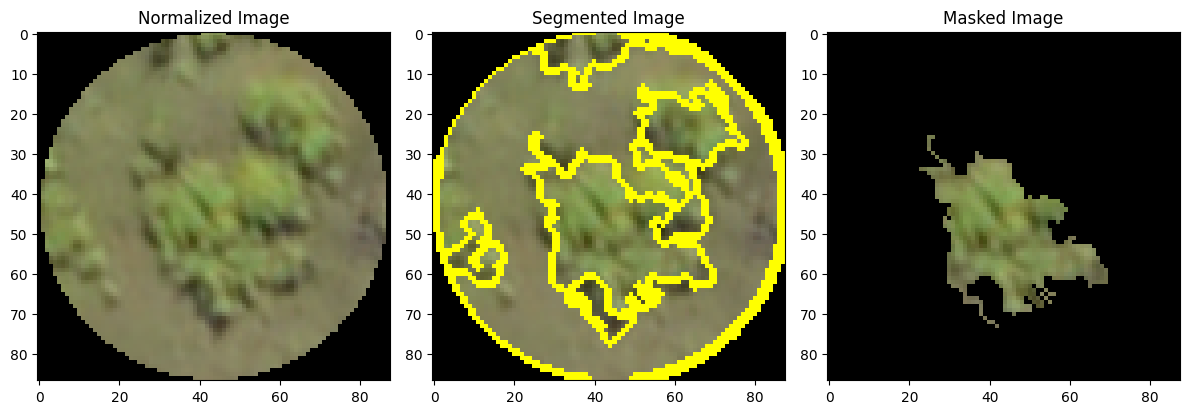

In [109]:
cropped_rgb_7cm = rasterio.open(f"{cropped_tif_fns[3]}")
# convert raster to numpy array
cropped_rgb_7cm_np = cropped_rgb_7cm.read().transpose(1, 2, 0)
img_rgb = cropped_rgb_7cm_np[:, :, :3]
logger.info(f'RGB image shape: {img_rgb.shape}')
segments_fz = felzenszwalb(img_rgb, scale=150, sigma=0.5, min_size=100)
mask = create_center_segment_mask(segments_fz, img_rgb.shape)
masked_image = apply_mask(img_rgb, mask)
plot_images(img_rgb, segments_fz, masked_image)

15-Nov-23 02:01:19 - INFO - RGB image shape: (87, 87, 3)


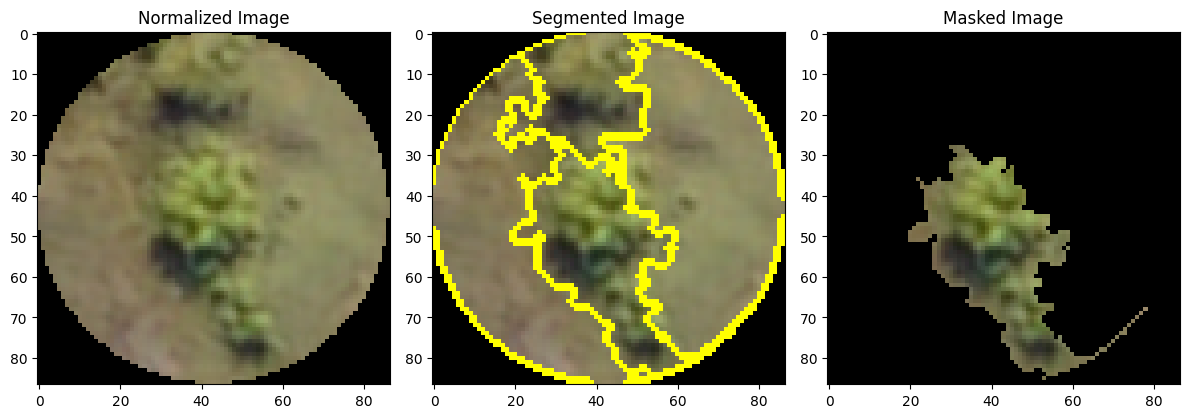

In [110]:
cropped_rgb_7cm = rasterio.open(f"{cropped_tif_fns[4]}")
# convert raster to numpy array
cropped_rgb_7cm_np = cropped_rgb_7cm.read().transpose(1, 2, 0)
img_rgb = cropped_rgb_7cm_np[:, :, :3]
logger.info(f'RGB image shape: {img_rgb.shape}')
segments_fz = felzenszwalb(img_rgb, scale=150, sigma=0.5, min_size=100)
mask = create_center_segment_mask(segments_fz, img_rgb.shape)
masked_image = apply_mask(img_rgb, mask)
plot_images(img_rgb, segments_fz, masked_image)

In [60]:
min_value = np.min(cropped_rgb_7cm_np)
max_value = np.max(cropped_rgb_7cm_np)
min_value, max_value

(0, 255)

In [3]:
def load_cropped_tifs(path):
    return glob.glob(f'{path}*.tif')

def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalizes the pixel values of the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The normalized image.
    """
    normalized_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    logger.info(f'Normalized image shape: {normalized_image.shape}')
    return normalized_image

def process_rgb_image(image: np.ndarray) -> np.ndarray:
    """
    Extracts the RGB channels from the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The RGB image.
    """
    # Add your RGB processing logic here
    img_rgb = image[:, :, :3]
    logger.info(f'RGB image shape: {img_rgb.shape}')
    return img_rgb


def get_segments(image: np.ndarray) -> np.ndarray:
    """
    Performs segmentation on the input image using the Felzenszwalb algorithm.

    Parameters:
    - image (numpy.ndarray): The input RGB image.

    Returns:
    - numpy.ndarray: The segmented image.
    """
    # Add your segmentation logic here
    segments_fz = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
    return segments_fz

# def segment_image(image: np.ndarray) -> np.ndarray:
#     """
#     Segments the input image to extract plant regions based on color.

#     Parameters:
#     - image (numpy.ndarray): The input RGB image.

#     Returns:
#     - numpy.ndarray: The segmented image containing only plant regions.
#     """
#     # Convert the image from RGB to HSV
#     hsv_image = rgb2hsv(image)
    
#     # Define the color range for the plants
#     lower_green = np.array([35/360, 0.2, 0.2])
#     upper_green = np.array([85/360, 1, 1])
    
#     # Create a mask for the plant segments
#     plant_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    
#     # Apply the mask to the image
#     plant_segments = cv2.bitwise_and(image, image, mask=plant_mask)
    
#     return plant_segments

# def segment_image(image: np.ndarray) -> np.ndarray:
#     """
#     Segments the input image to extract plant regions using adaptive thresholding.

#     Parameters:
#     - image (numpy.ndarray): The input RGB image.

#     Returns:
#     - numpy.ndarray: The segmented image containing only plant regions.
#     """
#     # Convert the image from RGB to HSV
#     hsv_image = rgb2hsv(image)

#     # Convert the HSV image to grayscale
#     gray_image = cv2.cvtColor(hsv_image, cv2.COLOR_BGR2GRAY)

#     # Convert the grayscale image to 8-bit unsigned integer
#     gray_image = np.uint8(gray_image)

#     # Apply adaptive thresholding (Otsu's method)
#     _, plant_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     # Create a mask with the same number of channels as the input image
#     plant_mask_rgb = cv2.cvtColor(plant_mask, cv2.COLOR_GRAY2RGB)

#     # Ensure the mask has the correct data type and size
#     plant_mask_rgb = np.uint8(plant_mask_rgb)

#     # Apply the mask to the original image
#     plant_segments = cv2.bitwise_and(image, image, mask=plant_mask_rgb)

#     return plant_segments

def rgb2hsv(image: np.ndarray) -> np.ndarray:
    """
    Converts an RGB image to HSV.

    Parameters:
    - image (numpy.ndarray): The input RGB image.

    Returns:
    - numpy.ndarray: The converted HSV image.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)


def segment_image(image: np.ndarray) -> np.ndarray:
    """
    Segments the input image to extract plant regions using adaptive thresholding.

    Parameters:
    - image (numpy.ndarray): The input RGB image.

    Returns:
    - numpy.ndarray: The segmented image containing only plant regions.
    """
    # Convert the image from RGB to HSV
    hsv_image = rgb2hsv(image)

    # # Extract the V channel from the HSV image
    # v_channel = hsv_image[:, :, 2]

    # Convert the HSV image to grayscale
    gray_image = cv2.cvtColor(hsv_image, cv2.COLOR_BGR2GRAY)

    # Scale the grayscale image from [0, 1] to [0, 255] and convert to uint8
    gray_image = (gray_image * 255).astype(np.uint8)

    # Apply adaptive thresholding (Gaussian method)
    plant_mask = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Create a mask with the same number of channels as the input image
    plant_mask_rgb = cv2.cvtColor(plant_mask, cv2.COLOR_GRAY2RGB)

    # Ensure the mask has the correct data type and size
    # plant_mask_rgb = np.uint8(plant_mask_rgb)

    # Apply the mask to the original image
    plant_segments = cv2.bitwise_and(image, image, mask=plant_mask_rgb)

    return plant_segments


def threshold_image(image: np.ndarray) -> np.ndarray:
    """
    Applies thresholding to the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The binary image after thresholding.
    """
    # Add your thresholding logic here
    thresh_sauvola = threshold_sauvola(image)
    binary_sauvola = image > thresh_sauvola
    return binary_sauvola

# def apply_mask_to_segments(image, segments, plant_segment_ids):
#     masked_image = np.zeros_like(image)
#     for segment_id in plant_segment_ids:
#         # Get the pixels of the segment
#         segment_mask = (segments == segment_id)
        
#         # Apply the mask to the segment and store the result in the masked image
#         masked_image[segment_mask] = image[segment_mask]
    
#     return masked_image

def apply_mask_to_segments(image: np.ndarray, segments: np.ndarray, 
                            plant_segment_ids: list) -> np.ndarray:
    """
    Applies a mask to specific segments in the input image.

    Parameters:
    - image (numpy.ndarray): The input image.
    - segments (numpy.ndarray): The segmentation map.
    - plant_segment_ids (list): List of segment IDs corresponding to plant regions.

    Returns:
    - numpy.ndarray: The masked image containing only the specified plant segments.
    """
    masked_image = np.zeros_like(image)
    
    if len(plant_segment_ids) == 0:  # If no plant segments are found
        # Calculate the sum of pixel values in each segment
        segment_sums = [np.sum(image[segments == segment_id]) for segment_id in np.unique(segments)]
        # Find the segment with the highest sum
        max_segment_id = np.argmax(segment_sums)
        # Add this segment to the plant_segment_ids
        plant_segment_ids.append(max_segment_id)
    
    for segment_id in plant_segment_ids:
        segment_mask = (segments == segment_id)
        masked_image[segment_mask] = image[segment_mask]
    
    return masked_image

def load_raster(image_path):
    with rasterio.open(image_path) as src:
        # Read the data and transpose the dimensions
        raster_data = src.read().transpose(1, 2, 0)
    return raster_data

def process_images(image_paths):
    normalized_images = []
    rgb_images = []
    imgs_segments = []
    masked_images = []

    for image_path in image_paths:
        raster_data = load_raster(image_path)
        logger.info(f'Raster data shape: {raster_data.shape}')

        normalized_image = normalize_image(raster_data)
        normalized_images.append(normalized_image)

        rgb_image = process_rgb_image(normalized_image)
        rgb_images.append(rgb_image)

        segments = get_segments(rgb_image)
        imgs_segments.append(segments)

        plant_segments = segment_image(rgb_image)

        # Replace 'plant_segment_ids' with the list of plant segment IDs
        masked_image = apply_mask_to_segments(rgb_image, segments, [1])
        masked_images.append(masked_image)

    return normalized_images, rgb_images, imgs_segments, masked_images

# def plot_images(normalized_images, rgb_images, segmented_images, masked_images):
#     num_images = len(normalized_images)

#     # Set up the plot with 4 columns
#     fig, axes = plt.subplots(nrows=num_images, ncols=4, figsize=(16, 4*num_images))

#     for i in range(num_images):
#         # Plot the normalized image in the first column
#         axes[i, 0].imshow(normalized_images[i])
#         axes[i, 0].set_title('Normalized Image')

#         # Plot the processed RGB image in the second column
#         axes[i, 1].imshow(rgb_images[i])
#         axes[i, 1].set_title('Processed RGB')

#         # Plot the processed image with boundaries in the third column
#         axes[i, 2].imshow(mark_boundaries(rgb_images[i], segmented_images[i]))
#         axes[i, 2].set_title('Segmented Image')

#         # Plot the masked image in the fourth column
#         axes[i, 3].imshow(masked_images[i])
#         axes[i, 3].set_title('Masked Image')

#     # Adjust layout to prevent clipping of titles
#     plt.tight_layout()
#     plt.show()

def plot_all_rasters(normalized_images, rgb_images, segmented_images, masked_images):
    num_images = len(normalized_images)

    # Set up the plot with 4 columns
    fig, axes = plt.subplots(nrows=num_images, ncols=4, figsize=(16, 4*num_images))

    for i in range(num_images):
        # Plot the normalized image in the first column
        axes[i, 0].imshow(normalized_images[i])
        axes[i, 0].set_title('Normalized Image')

        # Plot the processed RGB image in the second column
        axes[i, 1].imshow(rgb_images[i])
        axes[i, 1].set_title('Processed RGB')

        # Plot the processed image with boundaries in the third column
        axes[i, 2].imshow(mark_boundaries(rgb_images[i], segmented_images[i]))
        axes[i, 2].set_title('Segmented Image')

        # Plot the masked image in the fourth column
        axes[i, 3].imshow(masked_images[i])
        axes[i, 3].set_title('Masked Image')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()


def plot_images(normalized_image, segmented_image, masked_image):
    # Set up the plot with 4 columns
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 3))

    # for i in range(num_images):
    # Plot the normalized image in the first column
    axes[0].imshow(normalized_image)
    axes[0].set_title('Normalized Image')

    # Plot the processed RGB image in the second column
    # axes[1].imshow(rgb_image)
    # axes[1].set_title('Processed RGB')

    # Plot the processed image with boundaries in the third column
    axes[1].imshow(mark_boundaries(normalized_image, segmented_image))
    axes[1].set_title('Segmented Image')

    # Plot the masked image in the fourth column
    axes[2].imshow(masked_image)
    axes[2].set_title('Masked Image')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

In [4]:
cropped_fns_rgb = load_cropped_tifs(conf.data.path_pri_rgb)

In [14]:
raster_img = load_raster(cropped_fns_rgb[0])
logger.info(f'Raster data shape: {raster_img.shape}')

14-Nov-23 02:11:19 - INFO - Raster data shape: (37, 37, 4)


In [15]:
rgb_img = process_rgb_image(raster_img)

14-Nov-23 02:11:21 - INFO - RGB image shape: (37, 37, 3)


In [16]:
rgb_norm_img = normalize_image(rgb_img)
rgb_not_norm_img = cv2.normalize(rgb_norm_img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

14-Nov-23 02:11:21 - INFO - Normalized image shape: (37, 37, 3)


In [17]:
segments = get_segments(rgb_norm_img)

In [18]:
# # Assuming 'image' is your ndarray
min_value = np.min(rgb_img)
max_value = np.max(rgb_img)
min_value, max_value

(0.0, 186.0)

In [24]:
# def segment_image(image: np.ndarray) -> np.ndarray:
#     """
#     Segments the input image to extract plant regions using adaptive thresholding.

#     Parameters:
#     - image (numpy.ndarray): The input RGB image.

#     Returns:
#     - numpy.ndarray: The segmented image containing only plant regions.
#     """
#     # Convert the image from RGB to HSV
#     hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

#     # Extract the V channel from the HSV image
#     v_channel = hsv_image[:, :, 2]

#     # Scale the V channel from [0, 1] to [0, 255] and convert to uint8
#     v_channel = (v_channel * 255).astype(np.uint8)

#     # Apply adaptive thresholding (Gaussian method)
#     plant_mask = cv2.adaptiveThreshold(v_channel, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

#     # Create a mask with the same number of channels as the input image
#     plant_mask_rgb = cv2.cvtColor(plant_mask, cv2.COLOR_GRAY2RGB)

#     # Ensure the mask has the correct data type and size
#     plant_mask_rgb = np.uint8(plant_mask_rgb)

#     # Apply the mask to the original image
#     plant_segments = cv2.bitwise_and(image, image, mask=plant_mask_rgb)

#     return plant_segments

# def segment_image(image: np.ndarray) -> np.ndarray:
#     """
#     Segments the input image to extract plant regions using adaptive thresholding.

#     Parameters:
#     - image (numpy.ndarray): The input RGB image.

#     Returns:
#     - numpy.ndarray: The segmented image containing only plant regions.
#     """
#     # Convert the image from RGB to HSV
#     hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

#     # Extract the V channel from the HSV image
#     v_channel = hsv_image[:, :, 2]

#     # Apply adaptive thresholding (Gaussian method)
#     plant_mask = cv2.adaptiveThreshold(v_channel, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

#     # Apply the mask to the original image
#     plant_segments = cv2.bitwise_and(image, image, mask=plant_mask)

#     return plant_segments


def segment_image(image: np.ndarray) -> np.ndarray:
    """
    Segments the input image to extract plant regions using adaptive thresholding and morphological operations.

    Parameters:
    - image (numpy.ndarray): The input RGB image.

    Returns:
    - numpy.ndarray: The segmented image containing only plant regions.
    """
    # Convert the image from RGB to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Extract the V channel from the HSV image
    v_channel = hsv_image[:, :, 2]

    # Apply adaptive thresholding (Gaussian method)
    plant_mask = cv2.adaptiveThreshold(v_channel, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Define a kernel for morphological operations
    kernel = np.ones((3, 3), np.uint8)

    # Apply morphological opening to remove noise
    plant_mask = cv2.morphologyEx(plant_mask, cv2.MORPH_OPEN, kernel)

    # Apply morphological closing to fill small holes and smooth boundaries
    plant_mask = cv2.morphologyEx(plant_mask, cv2.MORPH_CLOSE, kernel)

    # Apply the mask to the original image
    plant_segments = cv2.bitwise_and(image, image, mask=plant_mask)

    return plant_segments

In [25]:
plant_segments = segment_image(rgb_not_norm_img)

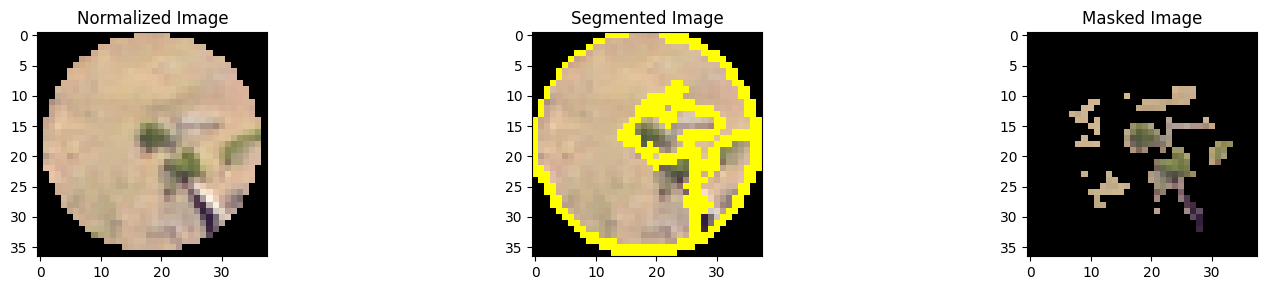

In [13]:
plot_images(rgb_norm_img, segments, plant_segments)

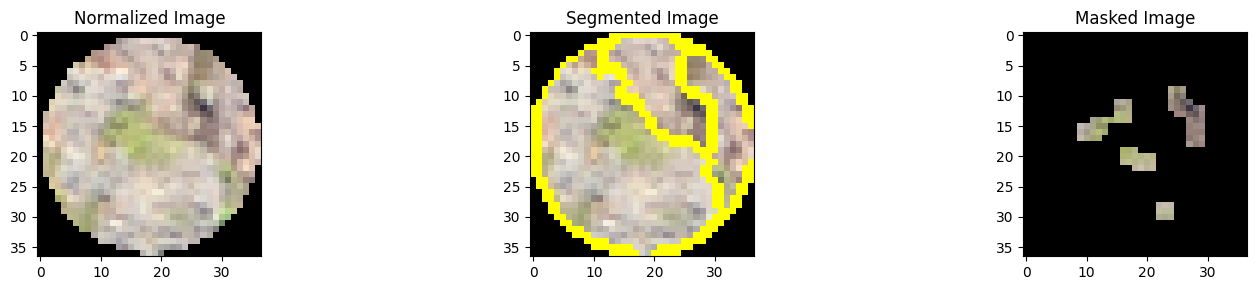

In [26]:
plot_images(rgb_norm_img, segments, plant_segments)

In [ ]:



# normalized_images.append(normalized_image)


# rgb_images.append(rgb_image)


# imgs_segments.append(segments)

plant_segments = segment_image(rgb_image)

# Replace 'plant_segment_ids' with the list of plant segment IDs
masked_image = apply_mask_to_segments(rgb_image, segments, [1])
# masked_images.append(masked_image)

In [ ]:
normalized_images, rgb_images, imgs_segments, masked_images = process_images(cropped_fns_rgb[:10])

In [ ]:
plot_images(normalized_images, rgb_images, imgs_segments, masked_images)

In [ ]:
from skimage.measure import regionprops, regionprops_table
import pandas as pd
import numpy as np

def extract_geometric_features(image):
    """
    Extract geometric features from a binary image of a leaf.
    
    Parameters:
    image (numpy.ndarray): Binary image of a leaf.
    
    Returns:
    pandas.DataFrame: DataFrame containing the geometric features.
    """
    props = regionprops(image)
    features = pd.DataFrame(regionprops_table(image, properties=('area', 'perimeter', 'eccentricity', 'extent')))
    features['aspect_ratio'] = props[0].major_axis_length / props[0].minor_axis_length
    features['roundness'] = 4 * np.pi * features['area'] / (features['perimeter'] ** 2)
    features['compactness'] = features['area'] / props[0].convex_area
    return features

In [ ]:
# Initialize arrays to store the color features
mean_colors = np.zeros((segments_fz.max() + 1, 3))  # for mean
std_colors = np.zeros((segments_fz.max() + 1, 3))  # for standard deviation

# Loop over each segment
for segment_id in np.unique(segments_fz):
    # Get the pixels of the segment
    segment_pixels = img[segments_fz == segment_id]
    # Calculate and store the mean and standard deviation of the RGB values of the segment
    mean_colors[segment_id] = segment_pixels.mean(axis=0)
    std_colors[segment_id] = segment_pixels.std(axis=0)

In [ ]:
# segments_qs = quickshift(img_rgb, ratio=0.5, kernel_size=3, max_dist=6, sigma=0)

In [ ]:
# fig, ax = plt.subplots(figsize = (20,20))
# plt.imshow(mark_boundaries(img_rgb, segments_qs))
# plt.show()